<a href="https://colab.research.google.com/github/shinnew9/cse337-cse437RL/blob/main/lab11_MBRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 11: Solving the mountaincar problem in 1 episode

In this lab, you will use a Gaussian Process (GP) model to learn the dynamics of the Mountain Car system.
Then, based on Lab 8, you will use MPPI or MPPI-Simplified to write the MPC loop that controls the vehicle.
The goal is to solve the Mountain Car problem in one episode.

## Provided code
* The following code implements a Gaussian Process regression model that predicts the next-state change (Δx) given [position, velocity, action].
* Example training data collected from random actions.



In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.9/279.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.7 MB/s eta 0:00:00


# Gaussian Process

In [3]:
import torch
import gpytorch
import numpy as np

# ============================================================
# ---- Base Exact GP model -------------------
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Choose kernel type
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RationalQuadraticKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ============================================================
# ---- Individual GP Manager: handles data + normalization ----
# ============================================================

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=1000):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.trained = False
        self.X_train = []
        self.Y_train = []

        self.likelihood = None
        self.model = None


    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        self.X_train = X.clone()
        self.Y_train = Y.clone()

        self.retrain()

    def retrain(self):
        # Normalize the input/output and then train the model
        self._compute_normalization()
        self._train_model()

    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True):
        """
        Add new data (single or batch) to GP training set.
        Optionally retrain the model.
        """
        X_new = torch.tensor(X_new, dtype=torch.float32)
        Y_new = torch.tensor(Y_new, dtype=torch.float32).flatten()  # ensure 1D

        # Also flatten stored Y to ensure shape consistency
        if self.Y_train.ndim > 1:
            self.Y_train = self.Y_train.flatten()

        # Append new data
        self.X_train = torch.cat([self.X_train, X_new], dim=0)
        self.Y_train = torch.cat([self.Y_train, Y_new], dim=0)

        if retrain:
            self.retrain()

    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self):
        self.X_mean, self.X_std = self.X_train.mean(0), self.X_train.std(0)
        self.Y_mean, self.Y_std = float(self.Y_train.mean(0)), float(self.Y_train.std(0))

        Xn = (self.X_train - self.X_mean) / self.X_std
        Yn = (self.Y_train - self.Y_mean) / self.Y_std

        self.Xn, self.Yn = Xn, Yn

    def dataset(self):
        # Extract training data (already stored inside the wrapper)
        X_train = self.X_train.numpy()
        Y_train = self.Y_train.numpy()
        return X_train, Y_train


    def _train_model(self):
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.likelihood.noise_covar.initialize(noise=1e-3)
        self.model = ExactGPModel(self.Xn, self.Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=self.X_train.shape[-1])

        # -------------------------------------------------
        # Train the model
        # -------------------------------------------------
        self.train_gp(self.model, self.likelihood, self.Xn, self.Yn)
        self.trained = True

    def train_gp(self, model, likelihood, x, y):
        model.train(); likelihood.train()
        opt = torch.optim.Adam(model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        for _ in range(self.iters):
            opt.zero_grad()
            out = model(x)
            loss = -mll(out, y)
            loss.backward()
            opt.step()
        model.eval(); likelihood.eval()

    def predict(self, X):
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        # Normalize the input
        X = torch.as_tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(Xn))

            # Unonormalize the output
            mean = pred.mean.cpu().numpy() * self.Y_std + self.Y_mean
            var = pred.variance.cpu().numpy() * (self.Y_std ** 2)
        # Return the unnormalized output
        return mean, var


# Setup environment and collect initial data

In [4]:
import gymnasium as gym
# import gym
import numpy as np
import torch
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# 1.  Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
n_state = env.observation_space.shape[0]    # [position, velocity]
n_action = env.action_space.shape[0]        # 1 continuous action
n_output = 2                                # Δpos, Δvel


# --------------------------------------------------------------
# 2.  Collect initial random data
# --------------------------------------------------------------
data = {'X': [], 'Y': []}

obs, _ = env.reset(seed=0)
for _ in range(200):  # collect 500 transitions
    a = env.action_space.sample()  # random continuous action in [-1,1]
    x_next, r, term, trunc, _ = env.step(a)
    data['X'].append(np.concatenate([obs, a]))   # [pos, vel, action]
    data['Y'].append(x_next - obs)               # Δstate
    obs = x_next
    if term or trunc:
        obs, _ = env.reset()

X = np.array(data['X'])[::3]
Y = np.array(data['Y'])[::3]
print(f"Collected {len(X)} transitions.")


# --------------------------------------------------------------
# 3.  Train GP dynamics models
# --------------------------------------------------------------
gps = [GPManager(kernel='RBF', iters=300) for _ in range(n_output)]

for d in range(n_output):
    gps[d].fit(X, Y[:, d])
    print(f"Trained GP for Δstate[{d}] with {len(X)} samples.")


Collected 67 transitions.
Trained GP for Δstate[0] with 67 samples.
Trained GP for Δstate[1] with 67 samples.


# Visualize collected data

Plotting for action a=-1.0
Values near action a=-1.0 n=18


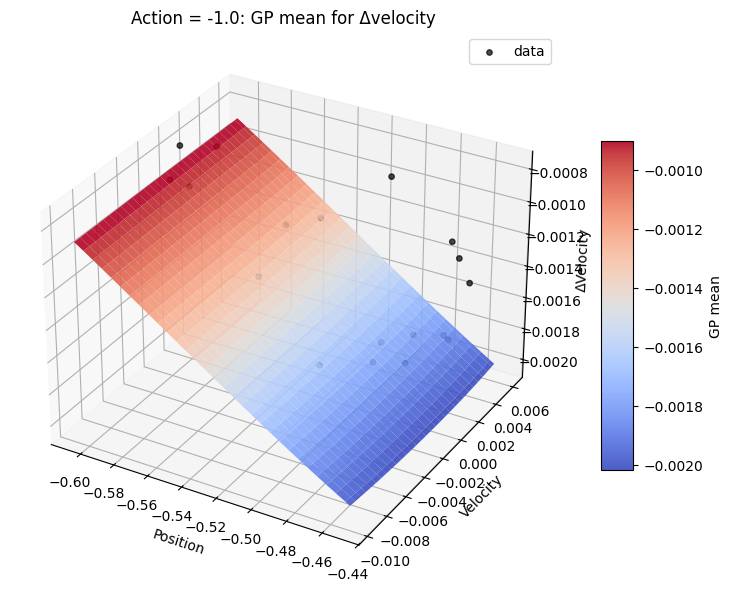

Plotting for action a=0.0
Values near action a=0.0 n=36


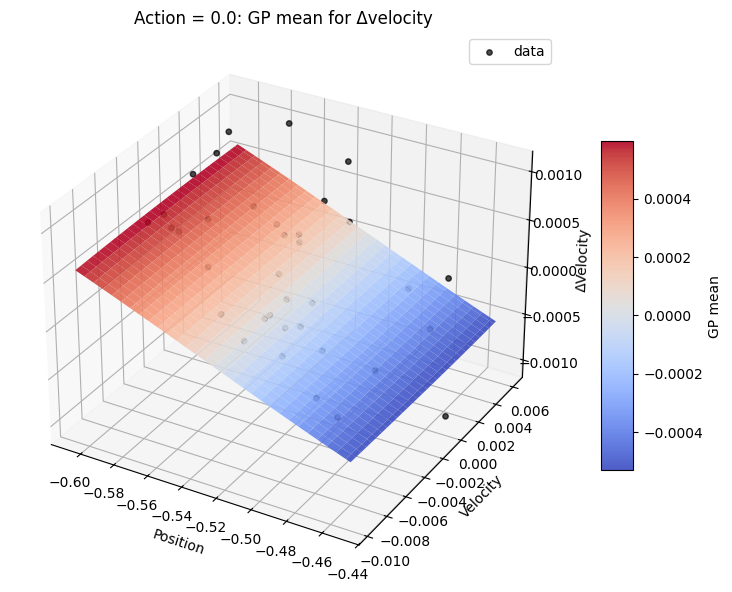

Plotting for action a=1.0
Values near action a=1.0 n=13


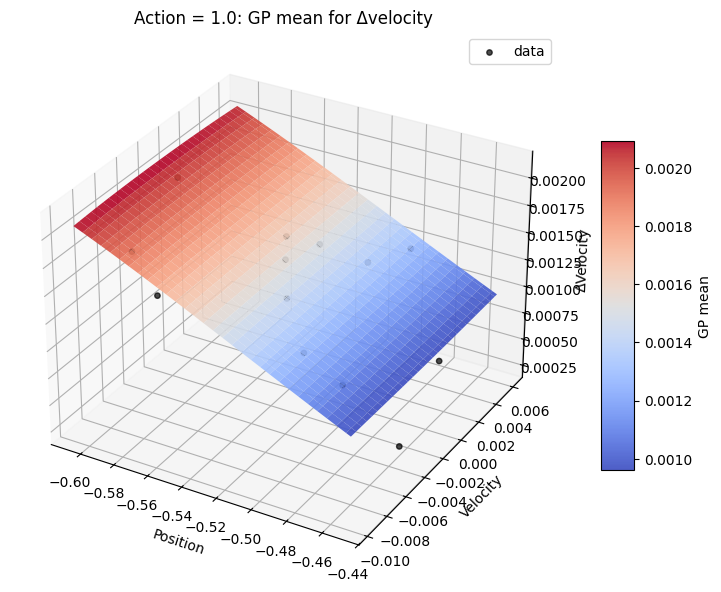

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --------------------------------------------------------
# Visualization setup
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity
a_values = [-1.0, 0.0, 1.0]  # representative actions

# Get raw training data
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train  # Δvelocity targets

# --------------------------------------------------------
# Define grid for visualization
# --------------------------------------------------------
p_min, p_max = pos.min(), pos.max()
v_min, v_max = vel.min(), vel.max()

p_grid = np.linspace(p_min, p_max, 60)
v_grid = np.linspace(v_min, v_max, 60)
P, V = np.meshgrid(p_grid, v_grid)

# --------------------------------------------------------
# Generate and plot for each action
# --------------------------------------------------------
for a_fixed in a_values:
    print(f"Plotting for action a={a_fixed}")

    # Predict using the GP for this action
    X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])
    Mean, var = gp.predict(X_grid)
    Mean = Mean.reshape(P.shape)

    # --------------------------------------------------------
    # Plot as surface
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(P, V, Mean, cmap='coolwarm',
                           linewidth=0, antialiased=True, alpha=0.9)

    # Overlay training data close to this action value
    mask = np.abs(act - a_fixed) < 0.5
    print(f"Values near action a={a_fixed} n={np.sum(mask)}")
    ax.scatter(pos[mask], vel[mask], dvel[mask],
               color='k', s=15, alpha=0.7, label='data')

    # --------------------------------------------------------
    # Labels and title
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('ΔVelocity')
    ax.set_title(f"Action = {a_fixed:.1f}: GP mean for Δvelocity")

    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='GP mean')
    ax.legend()
    plt.tight_layout()
    plt.show()


Values near action a=-1.0 → n=18


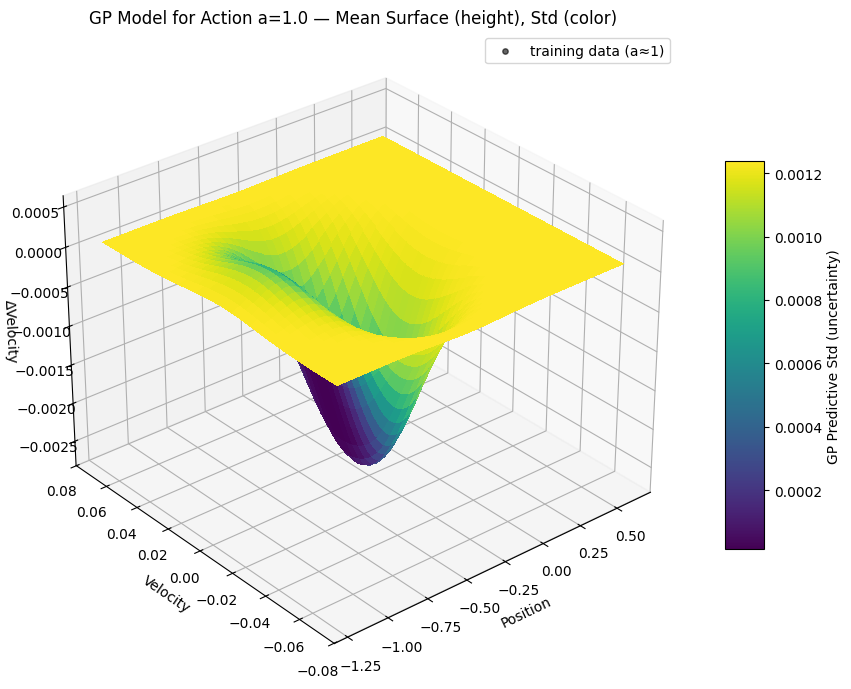

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------------------------------------
# Choose which GP to visualize
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity (index 0 for Δposition)
a_fixed = -1.0 # fixed continuous action (maximum thrust)

# --------------------------------------------------------
# Get training data
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train

# Select samples close to a=1 for overlay
mask = np.abs(act - a_fixed) < 0.5
print(f"Values near action a={a_fixed} → n={np.sum(mask)}")

# --------------------------------------------------------
# Define position–velocity grid
# --------------------------------------------------------
p_min, p_max = -1.2, 0.6
v_min, v_max = -0.07, 0.07
p_grid = np.linspace(p_min, p_max, 80)
v_grid = np.linspace(v_min, v_max, 80)
P, V = np.meshgrid(p_grid, v_grid)

# Query points for the fixed action
X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])

# --------------------------------------------------------
# GP predictions
# --------------------------------------------------------
Mean, Var = gp.predict(X_grid)
Mean = Mean.reshape(P.shape)
Std = np.sqrt(Var.reshape(P.shape))

# Normalize Std for color mapping
norm = plt.Normalize(vmin=Std.min(), vmax=Std.max())
colors = plt.cm.viridis(norm(Std))

# --------------------------------------------------------
# Plot surface: Mean as height, Std as color
# --------------------------------------------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    P, V, Mean,
    facecolors=colors, linewidth=0, antialiased=False, shade=False
)

# Colorbar = predictive uncertainty
m = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
m.set_array(Std)
cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('GP Predictive Std (uncertainty)')

# Overlay raw data (samples with similar a)
ax.scatter(
    pos[mask], vel[mask], dvel[mask],
    color='k', s=15, alpha=0.6, label='training data (a≈1)'
)

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('ΔVelocity')
ax.set_title("GP Model for Action a=1.0 — Mean Surface (height), Std (color)")
ax.view_init(elev=30, azim=230)
ax.legend()
plt.tight_layout()
plt.show()


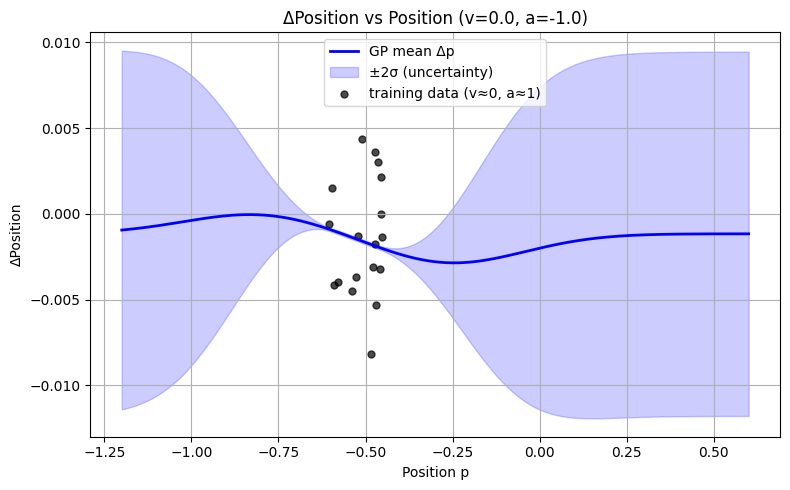

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------
# Choose GP: Δposition model
# --------------------------------------------------------
gp = gps[0]       # GP for Δposition
v_fixed = 0.0     # fix velocity
a_fixed = -1.0     # fix action

# --------------------------------------------------------
# Define position grid
# --------------------------------------------------------
p_min, p_max = -1.2, 0.6
p_grid = np.linspace(p_min, p_max, 200)

# Construct query points [p, v_fixed, a_fixed]
X_query = np.column_stack([p_grid, np.full_like(p_grid, v_fixed), np.full_like(p_grid, a_fixed)])

# --------------------------------------------------------
# Predict GP mean and std
# --------------------------------------------------------
Mean, Var = gp.predict(X_query)
Std = np.sqrt(Var)

# --------------------------------------------------------
# Plot mean ± std as shaded region
# --------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(p_grid, Mean, 'b-', lw=2, label='GP mean Δp')
plt.fill_between(p_grid, Mean - 2*Std, Mean + 2*Std,
                 color='blue', alpha=0.2, label='±2σ (uncertainty)')

# --------------------------------------------------------
# Overlay training data near v=0 and a=1
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
mask = (np.abs(X_train[:, 1] - v_fixed) < 0.01) & (np.abs(X_train[:, 2] - a_fixed) < 0.5)
plt.scatter(X_train[mask, 0], Y_train[mask], color='k', s=25, alpha=0.7, label='training data (v≈0, a≈1)')

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
plt.xlabel("Position p")
plt.ylabel("ΔPosition")
plt.title(f"ΔPosition vs Position (v={v_fixed}, a={a_fixed})")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Exercise 1
Use the trained GP as a learned dynamics model to control the Mountain Car environment using Model Predictive Control (MPC).

You can choose between:
* MPPI (Model Predictive Path Integral) – probabilistic trajectory weighting, or
* MPPI-Simplified (Random Shooting) – select the lowest-cost trajectory among random samples.

Your controller should plan ahead, predict future states using the GP, and drive the car to reach the goal in a single episode.

### Expected Outcome
By the end of the exercise, your controller should:
* Use the GP model to predict the system dynamics
* Plan and select optimal actions using MPC
* Drive the car to reach the goal in one episode

### Deliverables

* Your implementation of the mpc_action() function
* A plot showing the car’s position versus time
* A short explanation (2–3 sentences) describing how MBRL is more efficient than Q-learning.
* Describe the downside of MBRL over Q-learning

# MPC


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# 1) Use trained GPs (gps[0] = Δpos, gps[1] = Δvel) as dynamics
# --------------------------------------------------------------
def gp_dynamics(state, action, gps):
    """
    state: np.array([p, v])
    action: scalar or shape (1,)
    gps: list of 2 GPManager objects [gp_pos, gp_vel]
    returns: next_state np.array([p_next, v_next])
    """
    p, v = state
    a = float(action)  # ensure scalar
    x_in = np.array([[p, v, a]], dtype=np.float32)   # shape (1,3)

    # predict Δp, Δv from each GP
    dpos_mean, _ = gps[0].predict(x_in)
    dvel_mean, _ = gps[1].predict(x_in)

    p_next = p + dpos_mean[0]
    v_next = v + dvel_mean[0]

    # optional: clip to mountain car limits
    v_next = np.clip(v_next, -0.07, 0.07)
    if p_next < -1.2:
        p_next, v_next = -1.2, 0.0

    return np.array([p_next, v_next], dtype=np.float32)


# --------------------------------------------------------------
# 2) Cost function (Similar with Lab 9)
# --------------------------------------------------------------
def mc_cost(state, action, goal=0.5):
    x, v = state
    # goal에 가까울수록 좋고, 너무 빠르게 움직이면 벌점
    return (goal - x) ** 2 - 1000.0 * np.abs(v)


# --------------------------------------------------------------
# 3) Roll out one trajectory through GP dynamics
# --------------------------------------------------------------
def rollout_trajectory_gp(s0, actions, gps, gamma=1.0):
    s = s0.copy()
    traj = [s.copy()]
    total_cost = 0.0
    disc = 1.0

    for a in actions:
        s = gp_dynamics(s, a, gps)
        traj.append(s.copy())
        total_cost += mc_cost(s, a) * disc
        disc *= gamma

    return np.array(traj), total_cost


# --------------------------------------------------------------
# 4) MPC (Random Shooting / MPPI-simplified)
# --------------------------------------------------------------
def mpc_action(state, gps, H=25, N_seq=200, gamma=1.0,
               plot=False, plot_best=5):
    """
    state: current np.array([p, v])
    gps: [gps[0], gps[1]]
    H: planning horizon
    N_seq: number of sampled action sequences
    """
    # 1. sample action sequences in [-1, 1]
    U = np.random.uniform(low=-1.0, high=1.0, size=(N_seq, H))

    # 2. roll out
    all_traj = []
    J = np.zeros(N_seq)
    for i in range(N_seq):
        traj, cost = rollout_trajectory_gp(state, U[i], gps, gamma=gamma)
        all_traj.append(traj)
        J[i] = cost

    # 3. pick best (lowest cost)
    best_idx = np.argsort(J)[:min(plot_best, N_seq)]
    best_seq_idx = best_idx[0]

    # 4. optionally plot predicted trajectories
    if plot:
        plt.figure(figsize=(6,4))
        for bi in best_idx:
            plt.plot(all_traj[bi][:, 0], alpha=0.8)
        plt.axhline(0.5, ls='--', c='gray', label='goal')
        plt.title("Predicted trajectories (GP-MPC)")
        plt.xlabel("planning step")
        plt.ylabel("position")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 5. return first action of best sequence
    best_action = U[best_seq_idx, 0]
    return np.array([best_action], dtype=np.float32)


# --------------------------------------------------------------
# 5) Run one episode in the real env using GP-MPC
# --------------------------------------------------------------
def run_episode_gp_mpc(env, gps, H=25, N_seq=200, render=False):
    obs, _ = env.reset(seed=0)
    # obs is [pos, vel] already for MountainCarContinuous
    state = obs.astype(np.float32)
    positions = [state[0]]

    done = False
    t = 0
    while not done and t < 500:
        a = mpc_action(state, gps, H=H, N_seq=N_seq, plot=False)
        obs, r, terminated, truncated, info = env.step(a)
        state = obs.astype(np.float32)
        positions.append(state[0])
        t += 1
        done = terminated or truncated
        if render:
            env.render()

    # plot position vs time
    plt.figure(figsize=(6,4))
    plt.plot(positions, label='position')
    plt.axhline(0.5, ls='--', c='gray', label='goal')
    plt.xlabel("time step")
    plt.ylabel("position")
    plt.title("Mountain Car position vs time (GP-based MPC)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return positions


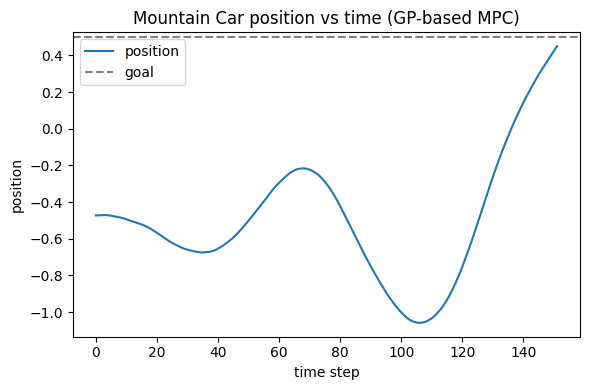

In [9]:
positions = run_episode_gp_mpc(env, gps, H=30, N_seq=300)


# Exercise 2 (Graduate students)
Extend the MPC controller from Exercise 1 by incorporating Gaussian Process (GP) uncertainty into the MPPI algorithm.
The goal is to study how including the GP’s predictive variance affects control performance and sample efficiency.


* Include GP uncertainty (variance) in the MPPI algorithm.
Modify the cost function or trajectory weighting so that trajectories passing through regions of high model uncertainty are penalized.

* Compare two systems:
  * MPPI using only the GP mean prediction (deterministic model).
  * MPPI using both the GP mean and variance (uncertainty-aware model).
* Evaluate and discuss the results:
  * The MBRL system from Exercise 1 usually solves the Mountain Car problem in more than 100 steps, even after several episodes.
  * Investigate whether incorporating uncertainty can help the controller reach the goal faster or with fewer samples.
  * Provide plots of position over time for both cases.

## Deliverables

* Your modified MPPI implementation that includes GP variance.
* Two plots comparing:
    * Position vs. time (with and without variance)
    * Cumulative reward or number of steps to reach the goal
* A short discussion (2–3 paragraphs) explaining how including uncertainty affects performance and why it might lead to better results.

In [10]:
def gp_dynamics_mean_var(state, action, gps):
  """
  state: [p, v]
  action: scalar
  gps: [gp_pos, gp_vel]
  returns:
    next_state_mean: np.array([p_next, v_next])
    next_state_var: np.array([var_p, var_v])  # GP predictive variance for deltas
  """

  p, v = state
  a = float(action)
  x_in = np.array([[p, v, a]], dtype=np.float32)

  dpos_mean, dpos_var = gps[0].predict(x_in)
  dvel_mean, dvel_var = gps[1].predict(x_in)

  p_next = p + dpos_mean[0]
  v_next = p + dvel_mean[0]

  # clip like before
  v_next = np.clip(v_next, -0.07, 0.07)
  if p_next < -1.2:
    p_next, v_next = -1.2, 0.0

  # return predicted next state AND the GP variance on the deltas
  return (
      np.array([p_next, v_next], dtype=np.float32),
      np.array([dpos_var[0], dvel_var[0]], dtype=np.float32),
  )

In [11]:
# Evaluating cost/trajectory
def mc_cost(state, action, goal=0.5):
  x, v = state
  return (goal-x)**2 - 1000.0 * np.abs(v)

In [12]:
# Extending to uncertainty aware:
def mc_cost_uncertainty(state, action, var_next, beta=5.0, goal=0.5):
  """
  var_next: np.array([var_dp, var_dv]) from GP
  beta: how hard to penalize uncertainty
  """

  base = mc_cost(state, action, goal=goal)
  # penalize going through uncertain regions
  unc_penalty = beta * (var_next[0] + var_next[1])
  return base + unc_penalty

3. MPPI-simplified (Random shooting + Uncertainty)

In [13]:
def rollout_traj_gp_uncertain(s0, actions, gps, gamma=1.0, beta=5.0):
  s = s0.copy()
  traj = [s.copy()]
  total_cost = 0.0
  disc = 1.0

  for a in actions:
    s_next, var_next = gp_dynamics_mean_var(s, a, gps)
    traj.append(s_next.copy())

    # use uncertainty-aware cost
    c = mc_cost_uncertainty(s_next, a, var_next, beta=beta)
    total_cost += c * disc

    s = s_next
    disc *= gamma

  return np.array(traj), total_cost

In [14]:
def mppi_uncertainty_action(state, gps, H=25, N_seq=200, gamma=1.0, beta=5.0, plot=False, plot_best=5):
  # 1) Sample Sequences
  U = np.random.uniform(low=-1.0, high=1.0, size=(N_seq, H))

  all_traj = []
  J = np.zeros(N_seq)

  # 2) roll out each with uncertainty-aware cost
  for i in range(N_seq):
    traj, cost = rollout_traj_gp_uncertain(state, U[i], gps, gamma=gamma, beta=beta)
    all_traj.append(traj)
    J[i] = cost

  # 3) pick best
  best_idx = np.argsort(J)[:min(plot_best, N_seq)]
  best_seq_idx = best_idx[0]

  if plot:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    for bi in best_idx:
      plt.plot(all_traj[bi][:,0], alppha = 0.8)
    plt.axhline(0.5, ls="--", c="gray")
    plt.title("Uncertaiy-aware MPPI predicted trajectories")
    plt.xlabel("planning step")
    plt.ylabel("position")
    plt.tight_layout()
    plt.show()

  best_action = U[best_seq_idx, 0]
  return np.array([best_action], dtype=np.float32)


In [15]:
def run_episode_controller(env, gps, controller_fn, max_steps=500, **ctrl_kwargs):
  obs, _ = env.reset(seed=0)
  state = obs.astype(np.float32)
  positions = [state[0]]
  rewards = []
  done = False
  t = 0
  while not done and t < max_steps:
    a = controller_fn(state, gps, **ctrl_kwargs)
    obs, r, terminated, truncated, info = env.step(a)
    state = obs.astype(np.float32)
    positions.append(state[0])
    rewards.append(r)
    done = terminated or truncated
    t += 1
  return np.array(positions), np.array(rewards)

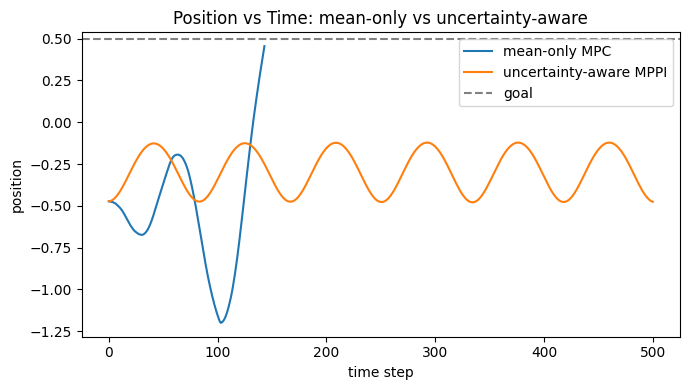

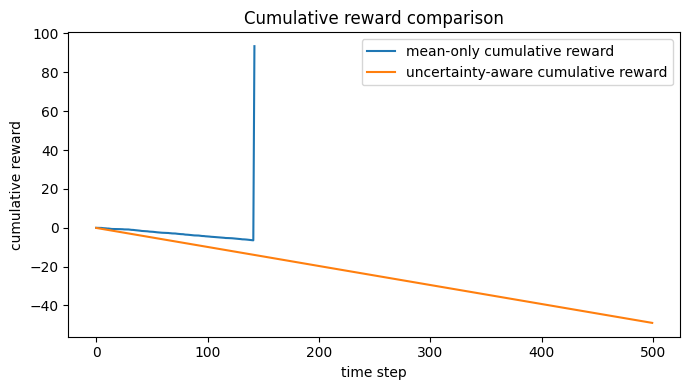

In [16]:
# 1) mean-only version (Exercise 1)
pos_mean, rew_mean = run_episode_controller(
    env, gps,
    controller_fn=lambda s, gps, **kw: mpc_action(s, gps, H=25, N_seq=200),
    max_steps=500
)

# 2) uncertainty-aware version
pos_unc, rew_unc = run_episode_controller(
    env, gps,
    controller_fn=lambda s, gps, **kw: mppi_uncertainty_action(s, gps,
                                                               H=25, N_seq=200,
                                                               beta=5.0),
    max_steps=500
)

# plot
plt.figure(figsize=(7,4))
plt.plot(pos_mean, label="mean-only MPC")
plt.plot(pos_unc, label="uncertainty-aware MPPI")
plt.axhline(0.5, ls='--', c='gray', label='goal')
plt.xlabel("time step")
plt.ylabel("position")
plt.title("Position vs Time: mean-only vs uncertainty-aware")
plt.legend()
plt.tight_layout()
plt.show()

# optional: cumulative reward
plt.figure(figsize=(7,4))
plt.plot(np.cumsum(rew_mean), label="mean-only cumulative reward")
plt.plot(np.cumsum(rew_unc), label="uncertainty-aware cumulative reward")
plt.xlabel("time step")
plt.ylabel("cumulative reward")
plt.title("Cumulative reward comparison")
plt.legend()
plt.tight_layout()
plt.show()
